In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# this is the code for the convtrans
import os
import sys
import argparse
import logging
import joblib
import pickle
import time
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from art import *
import matplotlib.pyplot as plt
from tqdm import tqdm

from Dataset.ECGDataset import ECGDataset

from Models.model import ConvTran_seq, ConvTran_timepos
from Models.loss import NoFussCrossEntropyLoss
from Models.optimizers import RAdam

sys.path.append(os.path.join(os.getcwd(), '../../..'))
from stage_code_cvt import stage_code
import file_paths

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
def load_data(data_path, patient_lut):
    X_train, y_train, X_test, y_test = [], [], [], []
    name_train, name_test = [], []
    for i in tqdm(range(len(patient_lut))):
        name = patient_lut.iloc[i]['name']
        split = patient_lut.iloc[i]['split']

        if not os.path.exists(os.path.join(data_path, name+'_combined.tsv')):
            continue
        
        sample = np.loadtxt(os.path.join(data_path, name+'_combined.tsv'), delimiter='\t')
        y = sample[:, 0]
        X = sample[:, 1:]
        name = [name] * y.shape[0]

        if split == 'train':
            X_train.extend(X)
            y_train.extend(y)
            name_train.extend(name)

        else:
            X_test.extend(X)
            y_test.extend(y)
            name_test.extend(name)

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    name_train = np.array(name_train)
    name_test = np.array(name_test)

    return X_train, y_train, X_test, y_test, name_train, name_test

In [19]:
data_cache_folder = './cache/'
cache_file_name = 'data.npz'
data_path = 'F:/Cellery/merry/data/label_window/ECG_Rate_010000_pos/'
patient_lut = pd.read_csv(file_paths.patient_lut_file)

if os.path.exists(data_cache_folder+cache_file_name):
    print("Loading data from cache")
    data = np.load(data_cache_folder+cache_file_name, allow_pickle=True)
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']
else:
    print("Loading data from source and saving cache")
    X_train, y_train, X_test, y_test, name_train, name_test = load_data(data_path, patient_lut)
    os.makedirs(os.path.dirname(data_cache_folder), exist_ok=True)
    np.savez(data_cache_folder+cache_file_name, 
        X_train=X_train, 
        y_train=y_train, 
        X_test=X_test, 
        y_test=y_test, 
        name_train=name_train, 
        name_test=name_test
    )

# drop label = -1
X_train = X_train[y_train != -1]
y_train = y_train[y_train != -1]
X_test = X_test[y_test != -1]
y_test = y_test[y_test != -1]


Loading data from source and saving cache


100%|██████████| 807/807 [00:30<00:00, 26.06it/s]


In [20]:
np.unique(y_train)

print('1s:', np.sum(y_train == 1), '0s:', np.sum(y_train == 0))

1s: 83164 0s: 435876


In [ ]:
train_dataset = ECGDataset(X_train, y_train, transform=True)
test_dataset = ECGDataset(X_test, y_test, transform=False)
# val_dataset, train_dataset = torch.utils.data.random_split(train_dataset, [len(train_dataset)//5, len(train_dataset)*4//5])

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [22]:
for X, time_pos, Y in train_loader:
    print(X.shape, time_pos.shape, Y.shape)
    break

torch.Size([512, 2, 150]) torch.Size([512]) torch.Size([512])


In [23]:
class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=1.5, alpha=0.3):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, input, target):
        pt = target * input + (1 - target) * (1 - input)
        ce = -torch.log(pt)
        loss = self.alpha * (1 - pt) ** self.gamma * ce
        return loss.mean()

In [ ]:
# load model
config = {
    'max_len': 150,
    'Data_shape': (0, 2, 150),
    'emb_size': 16,
    'num_heads': 8,
    'dim_ff': 256,
    'Fix_pos_encode': 'tAPE',
    'Rel_pos_encode': 'eRPE',
    'dropout': 0.01,
}


model = ConvTran_timepos(config, num_classes=1).to(device)

loss_module = torch.nn.BCELoss()
# loss_module = FocalLoss()
optimizer = RAdam(model.parameters(), lr=5e-3, weight_decay=1e-5)
EPOCHS = 50
l2_reg = 0

g:\Cellery\venv\myenv38\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [25]:
def l2_reg_loss(model):
    """Returns the squared L2 norm of output layer of given model"""

    for name, param in model.named_parameters():
        if name == 'output_layer.weight':
            return torch.sum(torch.square(param))

In [26]:
all_train_losses = []
all_val_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    for i, (X, time_pos, Y) in tqdm(enumerate(train_loader), total=len(train_loader)):
        X = X.to(device)
        time_pos = time_pos.to(device)
        Y = Y.to(device)

        pred = model(X, time_pos)
        loss = loss_module(pred.squeeze(1), Y)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=4.0)
        optimizer.step()

        with torch.no_grad():
            epoch_loss += loss.item()  # add total loss of batch

    epoch_loss = epoch_loss / len(train_loader)
    all_train_losses.append(epoch_loss)

    # validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        val_total_samples = 0
        for i, (X, time_pos, Y) in enumerate(test_loader):
            X = X.to(device)
            time_pos = time_pos.to(device)
            Y = Y.to(device)

            pred = model(X, time_pos)
            loss = loss_module(pred.squeeze(1), Y)
            val_loss += loss.item()

        val_loss = val_loss / len(test_loader)
        all_val_losses.append(val_loss)
    
    # print(f'Epoch {epoch} | Train Loss: {epoch_loss} ')
    print(f'Epoch {epoch} | Train Loss: {epoch_loss} | Val Loss: {val_loss}')

  0%|          | 0/1014 [00:00<?, ?it/s]g:\Cellery\venv\myenv38\lib\site-packages\torch\nn\modules\conv.py:443: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:744.)
  return F.conv2d(input, weight, bias, self.stride,
g:\Cellery\merry_submit\Sleep_stage_classifier\Local_classifacation\ConvTran\Models\optimizers.py:103: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\python_arg_parser.cpp:1055.)
  p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
100%|██████████| 1014/1014 [02:23<00:00,  7.07it/s]


Epoch 0 | Train Loss: 0.41121890923445514 | Val Loss: 0.3649488874540037


100%|██████████| 1014/1014 [01:42<00:00,  9.94it/s]


Epoch 1 | Train Loss: 0.3486572217482787 | Val Loss: 0.35561600294040174


100%|██████████| 1014/1014 [01:46<00:00,  9.54it/s]


Epoch 2 | Train Loss: 0.32577631218428676 | Val Loss: 0.3124082962469179


100%|██████████| 1014/1014 [01:45<00:00,  9.57it/s]


Epoch 3 | Train Loss: 0.3146695104635209 | Val Loss: 0.3092103358434171


100%|██████████| 1014/1014 [01:45<00:00,  9.61it/s]


Epoch 4 | Train Loss: 0.3070574729929309 | Val Loss: 0.29803827620890677


100%|██████████| 1014/1014 [01:46<00:00,  9.56it/s]


Epoch 5 | Train Loss: 0.3028463459990669 | Val Loss: 0.29846582545005546


100%|██████████| 1014/1014 [01:46<00:00,  9.55it/s]


Epoch 6 | Train Loss: 0.29940099194205017 | Val Loss: 0.2858125037076522


100%|██████████| 1014/1014 [01:46<00:00,  9.53it/s]


Epoch 7 | Train Loss: 0.29634259501563964 | Val Loss: 0.2897789717937002


100%|██████████| 1014/1014 [01:46<00:00,  9.54it/s]


Epoch 8 | Train Loss: 0.29372549494930505 | Val Loss: 0.28824956873241736


100%|██████████| 1014/1014 [01:46<00:00,  9.55it/s]


Epoch 9 | Train Loss: 0.2917225550441347 | Val Loss: 0.2888240112637987


100%|██████████| 1014/1014 [01:44<00:00,  9.70it/s]


Epoch 10 | Train Loss: 0.28889762567580335 | Val Loss: 0.28296458471794517


100%|██████████| 1014/1014 [01:41<00:00,  9.99it/s]


Epoch 11 | Train Loss: 0.2878926727604819 | Val Loss: 0.27972664539607206


100%|██████████| 1014/1014 [01:45<00:00,  9.57it/s]


Epoch 12 | Train Loss: 0.2853079548131314 | Val Loss: 0.2847490771388521


100%|██████████| 1014/1014 [01:46<00:00,  9.54it/s]


Epoch 13 | Train Loss: 0.28357623771744134 | Val Loss: 0.27721494606563024


100%|██████████| 1014/1014 [01:46<00:00,  9.56it/s]


Epoch 14 | Train Loss: 0.28246286495256234 | Val Loss: 0.2929002631987844


100%|██████████| 1014/1014 [01:46<00:00,  9.56it/s]


Epoch 15 | Train Loss: 0.28182530051916543 | Val Loss: 0.284432511335733


100%|██████████| 1014/1014 [01:46<00:00,  9.55it/s]


Epoch 16 | Train Loss: 0.28019489402307796 | Val Loss: 0.2853633526484577


100%|██████████| 1014/1014 [01:43<00:00,  9.81it/s]


Epoch 17 | Train Loss: 0.27939602426993543 | Val Loss: 0.28262728175946644


100%|██████████| 1014/1014 [01:45<00:00,  9.62it/s]


Epoch 18 | Train Loss: 0.27722613185761713 | Val Loss: 0.2863160238430208


100%|██████████| 1014/1014 [01:44<00:00,  9.68it/s]


Epoch 19 | Train Loss: 0.27713441923701554 | Val Loss: 0.28978269583716687


100%|██████████| 1014/1014 [01:45<00:00,  9.64it/s]


Epoch 20 | Train Loss: 0.2754529927814971 | Val Loss: 0.3065873312554797


100%|██████████| 1014/1014 [01:44<00:00,  9.67it/s]


Epoch 21 | Train Loss: 0.2754274855498261 | Val Loss: 0.2796991401180929


100%|██████████| 1014/1014 [01:45<00:00,  9.63it/s]


Epoch 22 | Train Loss: 0.2738813681921075 | Val Loss: 0.27877966037818364


100%|██████████| 1014/1014 [01:44<00:00,  9.73it/s]


Epoch 23 | Train Loss: 0.2732307174090568 | Val Loss: 0.27737382401009


100%|██████████| 1014/1014 [01:45<00:00,  9.61it/s]


Epoch 24 | Train Loss: 0.27299625646962217 | Val Loss: 0.29714710715473913


100%|██████████| 1014/1014 [01:43<00:00,  9.82it/s]


Epoch 25 | Train Loss: 0.27166758903855165 | Val Loss: 0.2800413067699695


100%|██████████| 1014/1014 [01:45<00:00,  9.59it/s]


Epoch 26 | Train Loss: 0.27109652450510263 | Val Loss: 0.2805308248771697


100%|██████████| 1014/1014 [01:41<00:00,  9.95it/s]


Epoch 27 | Train Loss: 0.27066608478684395 | Val Loss: 0.28288988186692704


100%|██████████| 1014/1014 [01:41<00:00, 10.01it/s]


Epoch 28 | Train Loss: 0.26973092807291527 | Val Loss: 0.27643437450941727


100%|██████████| 1014/1014 [01:39<00:00, 10.23it/s]


Epoch 29 | Train Loss: 0.2694586919109967 | Val Loss: 0.27642916603660095


100%|██████████| 1014/1014 [01:40<00:00, 10.09it/s]


Epoch 30 | Train Loss: 0.26890519252542916 | Val Loss: 0.2791208168377682


100%|██████████| 1014/1014 [01:40<00:00, 10.13it/s]


Epoch 31 | Train Loss: 0.26780047868718293 | Val Loss: 0.2799212128228071


100%|██████████| 1014/1014 [01:38<00:00, 10.28it/s]


Epoch 32 | Train Loss: 0.26744717625530046 | Val Loss: 0.2811390535867944


100%|██████████| 1014/1014 [01:35<00:00, 10.63it/s]


Epoch 33 | Train Loss: 0.26711494097930677 | Val Loss: 0.29094608261877175


100%|██████████| 1014/1014 [01:34<00:00, 10.69it/s]


Epoch 34 | Train Loss: 0.266727296573053 | Val Loss: 0.2825015330953257


100%|██████████| 1014/1014 [01:33<00:00, 10.86it/s]


Epoch 35 | Train Loss: 0.26534814237666554 | Val Loss: 0.27785943168766647


100%|██████████| 1014/1014 [01:35<00:00, 10.58it/s]


Epoch 36 | Train Loss: 0.265223003821025 | Val Loss: 0.29334882356378494


100%|██████████| 1014/1014 [01:39<00:00, 10.19it/s]


Epoch 37 | Train Loss: 0.2649745963058293 | Val Loss: 0.2781148013715841


100%|██████████| 1014/1014 [01:40<00:00, 10.11it/s]


Epoch 38 | Train Loss: 0.2643525942395895 | Val Loss: 0.2834917871623623


100%|██████████| 1014/1014 [01:31<00:00, 11.10it/s]


Epoch 39 | Train Loss: 0.2640656926898796 | Val Loss: 0.28238696376888117


100%|██████████| 1014/1014 [01:31<00:00, 11.07it/s]


Epoch 40 | Train Loss: 0.2638856994329825 | Val Loss: 0.2822576046294096


100%|██████████| 1014/1014 [01:35<00:00, 10.62it/s]


Epoch 41 | Train Loss: 0.2628031954521964 | Val Loss: 0.2797952577471733


100%|██████████| 1014/1014 [01:31<00:00, 11.12it/s]


Epoch 42 | Train Loss: 0.2626750228349744 | Val Loss: 0.2804179884493351


100%|██████████| 1014/1014 [01:32<00:00, 10.94it/s]


Epoch 43 | Train Loss: 0.26250025184725867 | Val Loss: 0.29686140548817963


100%|██████████| 1014/1014 [01:34<00:00, 10.78it/s]


Epoch 44 | Train Loss: 0.2617302496551997 | Val Loss: 0.2774286326705193


100%|██████████| 1014/1014 [01:40<00:00, 10.08it/s]


Epoch 45 | Train Loss: 0.2609439191116384 | Val Loss: 0.2847157950456045


100%|██████████| 1014/1014 [01:37<00:00, 10.44it/s]


Epoch 46 | Train Loss: 0.26132634953693057 | Val Loss: 0.28447912241123163


100%|██████████| 1014/1014 [01:39<00:00, 10.16it/s]


Epoch 47 | Train Loss: 0.2603763237419213 | Val Loss: 0.28181754422126987


100%|██████████| 1014/1014 [01:39<00:00, 10.17it/s]


Epoch 48 | Train Loss: 0.26088430822130726 | Val Loss: 0.2793622734291213


100%|██████████| 1014/1014 [01:35<00:00, 10.61it/s]


Epoch 49 | Train Loss: 0.2599091389210972 | Val Loss: 0.2798541663556683


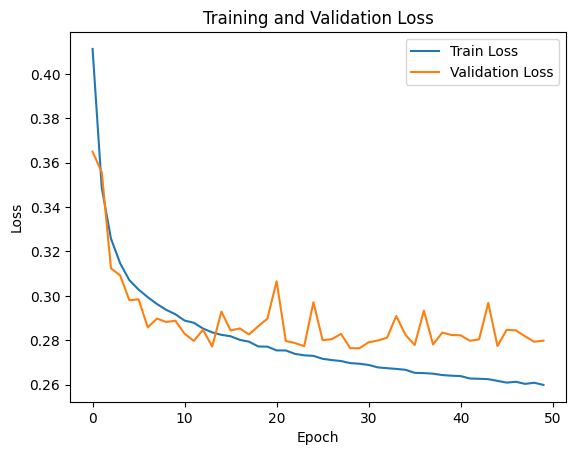

In [27]:
plt.figure()
plt.plot(all_train_losses, label='Train Loss')
plt.plot(all_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [28]:
# save model
import time
curr = time.strftime("%Y%m%d%H%M%S", time.localtime())
os.makedirs(f'./output/{curr}', exist_ok=True)
torch.save(model.state_dict(), f'./output/{curr}/model.pth')
print(f'Model saved to ./output/{curr}/model.pth')

Model saved to ./output/20250718172833/model.pth


In [97]:
# load model
# model = ConvTran_timepos(config, num_classes=1).to(device)
# curr = '20241125165230'
# model.load_state_dict(torch.load(f'./output/{curr}/model.pth'))

In [29]:
from sklearn.metrics import confusion_matrix

def classification_report(y_true, y_pred, mode='marco'):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / np.sum(cm)
    tn = []; fp = []; fn = []; tp = []
    for i in range(cm.shape[0]):
        tp.append(cm[i, i])
        fp.append(np.sum(cm[i, :]) - cm[i, i])
        fn.append(np.sum(cm[:, i]) - cm[i, i])
        tn.append(np.sum(cm) - tp[-1] - fp[-1] - fn[-1])

    tp = np.array(tp); fp = np.array(fp); fn = np.array(fn); tn = np.array(tn)

    # get sensitivity, MCC
    if mode == 'macro':
        sensitivity = np.mean(tp / (tp + fn))
        MCC = np.mean((tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    elif mode == 'micro':
        tp_ = sum(tp); fp_ = sum(fp); fn_ = sum(fn); tn_ = sum(tn)
        sensitivity = tp_ / (tp_ + fn_)
        MCC = (tp_*tn_ - fp_*fn_) / np.sqrt((tp_+fp_)*(tp_+fn_)*(tn_+fp_)*(tn_+fn_))
    else:
        raise ValueError('mode should be macro or micro')
    
    return sensitivity, MCC

In [30]:
# test for train dataset
model.eval()
total_loss = 0
total_samples = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for i, (X, time_pos, Y) in tqdm(enumerate(train_loader), total=len(train_loader)):
        X = X.to(device)
        time_pos = time_pos.to(device)
        Y = Y.to(device)

        pred = model(X, time_pos)
        loss = loss_module(pred.squeeze(1), Y)
        total_loss += loss.item()

        all_preds.extend(pred.squeeze(1).detach().cpu().numpy())
        all_labels.extend(Y.detach().cpu().numpy())

    total_loss = total_loss / len(train_loader)
    print(f'Test Loss: {total_loss}')

# confusion matrix
from sklearn.metrics import confusion_matrix

all_preds = np.array(all_preds)
all_preds = (all_preds > 0.5).astype(int)
all_labels = np.array(all_labels)

# classification report
sensitivity, MCC = classification_report(all_labels, all_preds, mode='macro')
print("Train")
print(confusion_matrix(all_labels, all_preds))
print(f'sensitivity: {sensitivity}, MCC: {MCC}')


100%|██████████| 1014/1014 [01:15<00:00, 13.41it/s]


Test Loss: 0.253987256488974
Train
[[425723  10153]
 [ 45139  38025]]
sensitivity: 0.8466980263131006, MCC: 0.548533816930739


In [32]:
# test
model.eval()
total_loss = 0
total_samples = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for i, (X, time_pos, Y) in tqdm(enumerate(test_loader), total=len(test_loader)):
        X = X.to(device)
        time_pos = time_pos.to(device)
        Y = Y.to(device)

        pred = model(X, time_pos)
        loss = loss_module(pred.squeeze(1), Y)
        total_loss += loss.item()

        all_preds.extend(pred.squeeze(1).detach().cpu().numpy())
        all_labels.extend(Y.detach().cpu().numpy())

    total_loss = total_loss / len(test_loader)
    print(f'Test Loss: {total_loss}')

# confusion matrix
from sklearn.metrics import confusion_matrix

all_preds = np.array(all_preds)
all_preds = (all_preds > 0.5).astype(int)
all_labels = np.array(all_labels)


# print sensitivity, MCC
sensitivity, MCC = classification_report(all_labels, all_preds, mode='macro')
print("Test")
print(confusion_matrix(all_labels, all_preds))
print(f'sensitivity: {sensitivity}, MCC: {MCC}')

100%|██████████| 245/245 [00:12<00:00, 20.16it/s]


Test Loss: 0.2798541663556683
Test
[[101605   3141]
 [ 11556   8802]]
sensitivity: 0.8174403826221495, MCC: 0.505429975975123


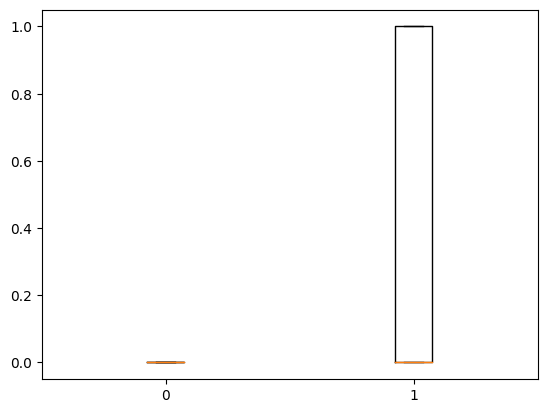

In [33]:
ind0 = np.where(all_labels == 0)
ind1 = np.where(all_labels == 1)

# boxplot
plt.figure()
plt.boxplot([all_preds[ind0], all_preds[ind1]], labels=['0', '1'], showfliers=False)
plt.show()

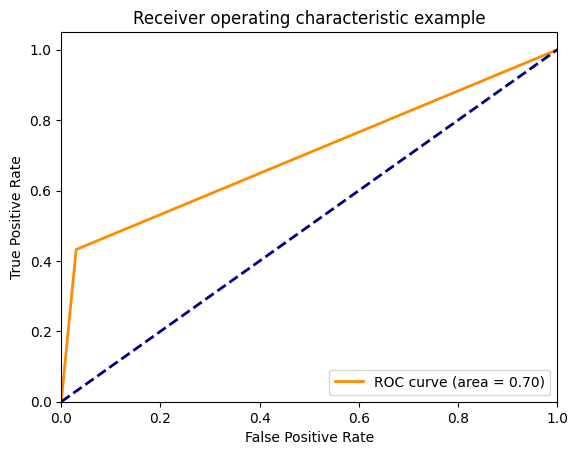

1.0


In [34]:
# auc curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# best threshold
best_threshold = thresholds[np.argmax(tpr - fpr)]
print(best_threshold)